In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
!pip install tweet-preprocessor

In [3]:
!pip install gensim

In [4]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import re

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [46]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [6]:
from datasets import load_dataset

In [7]:
raw_datasets = load_dataset("csv", data_files="/kaggle/input/nlp-getting-started/train.csv")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-53c3f88ac1a41e2e/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
raw_datasets_test = load_dataset("csv", data_files="/kaggle/input/nlp-getting-started/test.csv")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-73d3d51283c14fdf/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
tweet_dataset_clean = raw_datasets["train"].train_test_split(train_size=0.8, seed=42)
# Rename the default "test" split to "validation"
tweet_dataset_clean["validation"] = tweet_dataset_clean.pop("test")
# Add the "test" set to our `DatasetDict`
tweet_dataset_clean["test"] = raw_datasets_test["train"]
tweet_dataset_clean

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target'],
        num_rows: 6090
    })
    validation: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target'],
        num_rows: 1523
    })
    test: Dataset({
        features: ['id', 'keyword', 'location', 'text'],
        num_rows: 3263
    })
})

In [10]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

In [11]:
import preprocessor as p
from gensim.parsing.preprocessing import remove_stopwords

In [12]:
def preprocess_tweet(row):
    text = row['text']
    text = p.clean(text)
    text = remove_stopwords(text)
    text = text.lower()
    text = re.sub('[^\w\s]','',text)
    return {"text": text}

In [13]:
tweet_dataset_clean = tweet_dataset_clean.map(preprocess_tweet)

  0%|          | 0/6090 [00:00<?, ?ex/s]

  0%|          | 0/1523 [00:00<?, ?ex/s]

  0%|          | 0/3263 [00:00<?, ?ex/s]

In [14]:
tweet_dataset_clean['train']['text'][0:10]

['worst fear',
 'hes negotiating state terrorism world what hurry trying deal',
 'on confederate ship blown crew read more',
 'omg horrible accident man died wings airplane',
 '    mh370 aircraft debris la reunion missing malaysia airlines ',
 'there truthsof pain desire origin pain obliteration desire pain obliteration',
 'im utter shock devastation dont work left feeling i now life short ',
 'when answer friend isnt blowing windits yelling how survive dust storm',
 'county overload prompts use emergency plan during july celebrations',
 'theres truck parking lot']

In [15]:
tokenized_datasets = tweet_dataset_clean.map(tokenize_function, batched=True)
tokenized_datasets

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6090
    })
    validation: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1523
    })
    test: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3263
    })
})

In [16]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [17]:
tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["target"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size= 32,
)

tf_validation_dataset = tokenized_datasets["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["target"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size= 32,
)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [27]:
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels = 2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
from tensorflow import keras

In [28]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

batch_size = 32
num_epochs = 3
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate= 5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

In [30]:
from tensorflow.keras.optimizers.legacy import Adam

opt = Adam(learning_rate= lr_scheduler)

In [31]:
model.compile(optimizer=opt, loss= "sparse_categorical_crossentropy", metrics= tf.metrics.SparseCategoricalAccuracy())


In [32]:
model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [33]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',restore_best_weights=True)

In [34]:
history =  model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset, epochs= 3,
    callbacks=[early_stopping_cb]
)

Epoch 1/3
190/190 [==============================] - 84s 180ms/step - loss: 0.6731 - sparse_categorical_accuracy: 0.6969 - val_loss: 0.6503 - val_sparse_categorical_accuracy: 0.7879
Epoch 2/3
190/190 [==============================] - 28s 148ms/step - loss: 0.5328 - sparse_categorical_accuracy: 0.8141 - val_loss: 0.5040 - val_sparse_categorical_accuracy: 0.8102
Epoch 3/3
190/190 [==============================] - 28s 149ms/step - loss: 0.4958 - sparse_categorical_accuracy: 0.8533 - val_loss: 0.5405 - val_sparse_categorical_accuracy: 0.8194


In [43]:
from huggingface_hub import notebook_login

notebook_login()

In [44]:
model.push_to_hub("bert-base-uncased-disaster_tweetsv1")

tf_model.h5:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [47]:
tokenizer.push_to_hub("bert-base-uncased-disaster_tweetsv1")

CommitInfo(commit_url='https://huggingface.co/nitendra1729/bert-base-uncased-disaster_tweetsv1/commit/d917678219d5dac132dd11e1f45d5d4980cd1a1b', commit_message='Upload tokenizer', commit_description='', oid='d917678219d5dac132dd11e1f45d5d4980cd1a1b', pr_url=None, pr_revision=None, pr_num=None)

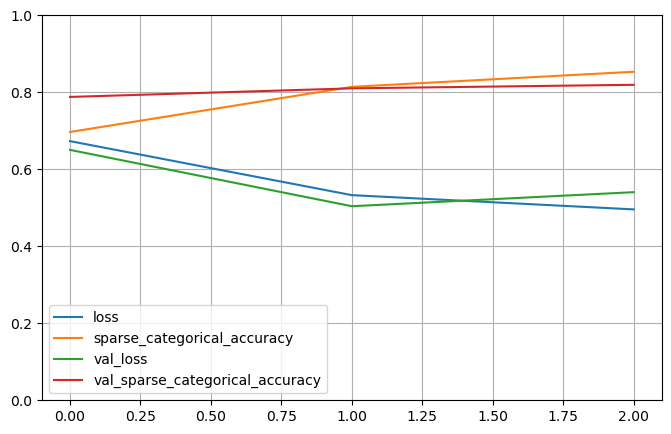

In [35]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [36]:
tf_test_dataset = tokenized_datasets["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=32,
)

In [37]:
predictions = model.predict(tf_test_dataset)

102/102 [==============================] - 9s 55ms/step


In [39]:
class_preds = np.argmax(predictions['logits'], axis=1)

In [40]:
Submission = pd.DataFrame(zip(tweet_dataset_clean["test"]['id'],class_preds),columns =['id', 'target'])
Submission = Submission.set_index('id')

In [41]:
Submission

,target
id,
0,1
2,1
3,1
9,0
11,1
...,...
10861,1
10865,1
10868,1


In [ ]:
Submission.to_csv("Submission.csv")